In [5]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%load_ext line_profiler
%load_ext memory_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [7]:
module = fc.eightb.preselection.ranked_quadh
signal = ObjIter([Tree(fn, use_gen=False) for fn in module.signal_list[::3]])
bkg = ObjIter([Tree(module.QCD_B_List, use_gen=False), Tree(module.TTJets, use_gen=False)])

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


100%|██████████| 3/3 [00:01<00:00,  1.72it/s]


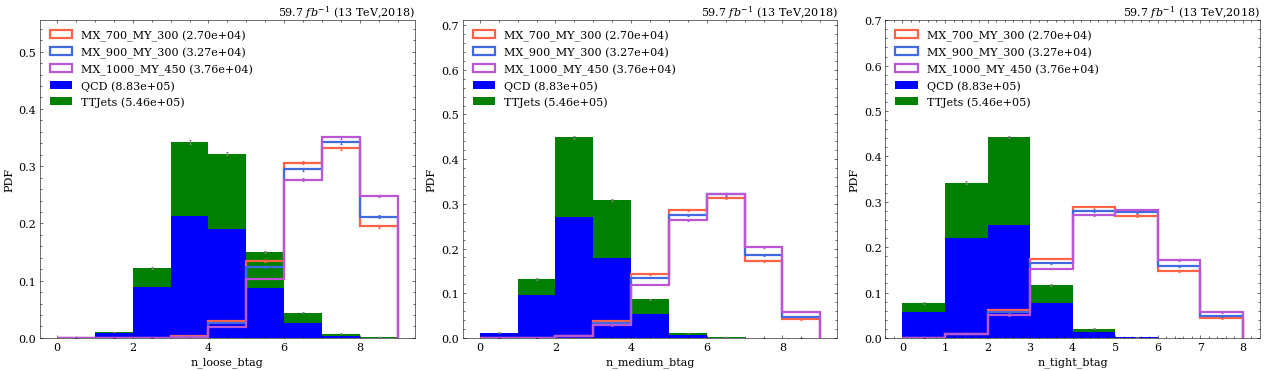

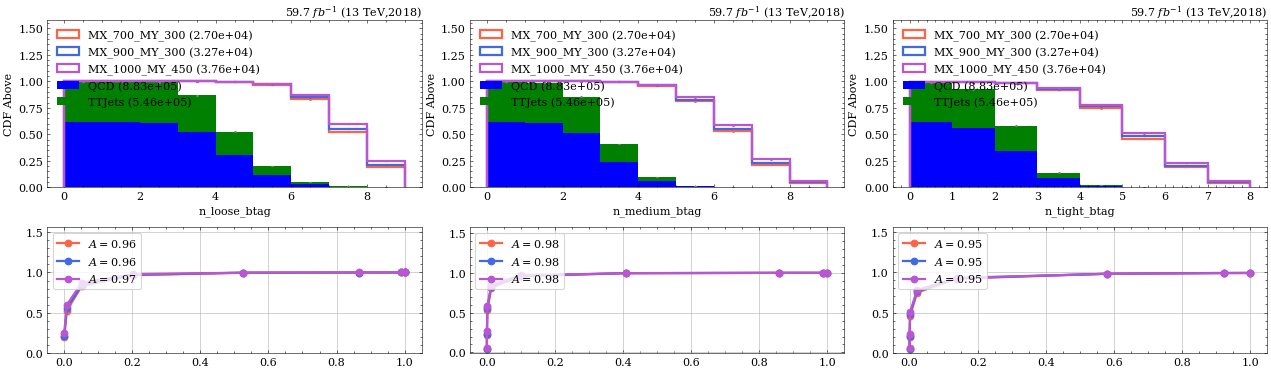

In [35]:
study.quick(
    signal+bkg, legend=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    dim=(-1,3),
    efficiency=True
)

study.quick(
    signal+bkg, legend=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    dim=(-1,3),
    cumulative=-1, correlation=True, c_legend_frameon=True,
)

In [8]:
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ptordered=True))
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY1_b\d', 'y1_jet', ptordered=True))
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY2_b\d', 'y2_jet', ptordered=True))
(signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ptordered=True))
(signal+bkg).apply(lambda t : build_collection(t, 'Y\d', 'y', ptordered=True))

[None, None, None, None, None]

In [68]:
def get_features(t):
  def get_y_features(t, y):
    et=np.sqrt(t[f'Y{y}_pt']**2 + t[f'Y{y}_m']**2)
    relht = ak.sum(t[f'y{y}_jet_ptRegressed'],axis=-1)/et
    btagavg = ak.mean(t[f'y{y}_jet_btag'],axis=-1)
    btagmulti = {f'Y{y}_{wplabels[wp+1]}_btag':ak.sum(t[f'y{y}_jet_btag']>jet_btagWP[wp+1], axis=-1) for wp in range(3)}
    return {
      f'Y{y}_et':et,
      f'Y{y}_relht':relht,
      f'Y{y}_btagavg':btagavg,
      **btagmulti
    }

  def get_j_features(t, i):
    label = {0:'even',1:'odd'}
    btagmulti = {f'{label.get(i)}_{wplabels[wp+1]}_btag':ak.sum(t.jet_btag[:,i::2]>jet_btagWP[wp+1], axis=-1) for wp in range(3)}
    btagmulti.update(
      **{f'{label.get(i)}_btagavg':ak.mean(t.jet_btag[:,i::2], axis=-1)}
    )
    return btagmulti


  t.extend(
    **get_y_features(t, 1),
    **get_y_features(t, 2),
    **get_j_features(t, 0),
    **get_j_features(t, 1),
  )

(signal+bkg).apply(get_features)

[None, None, None, None, None]

100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


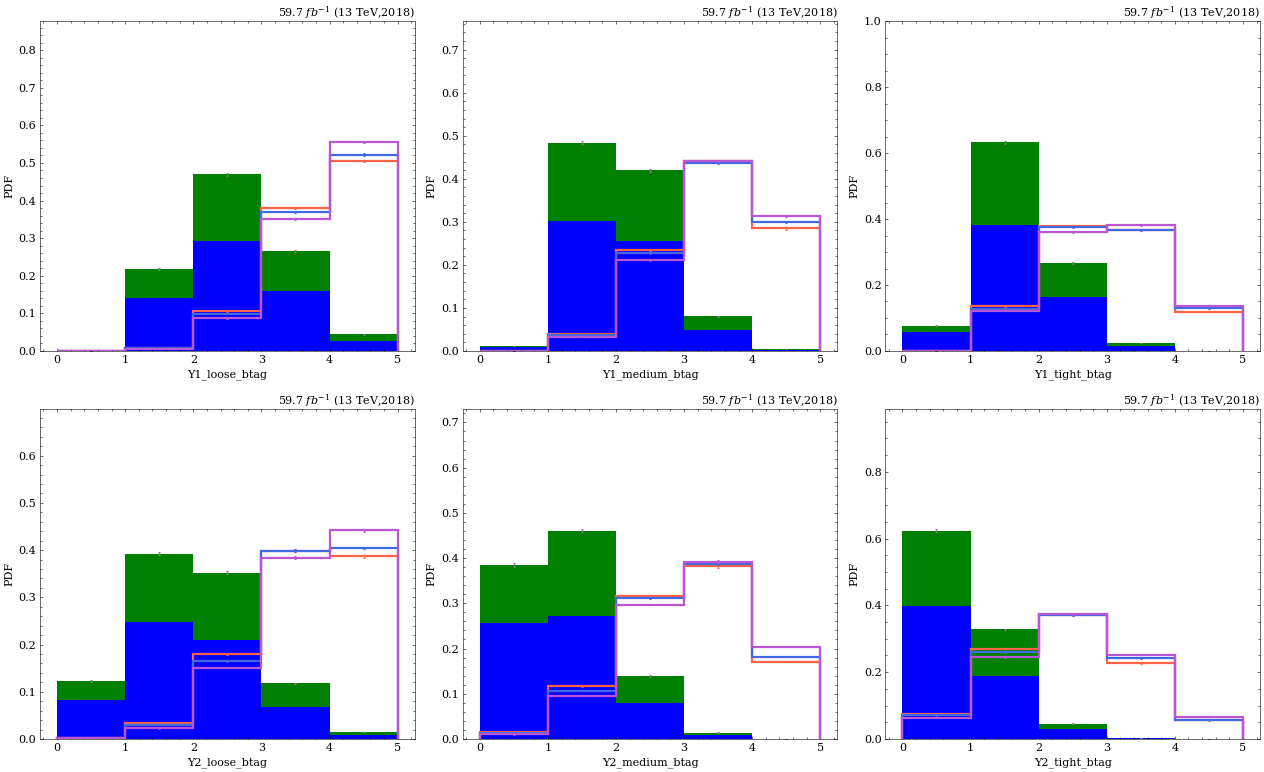

In [10]:
study.quick(
    signal + bkg,
    varlist=[f'{y}_{var}' for y in ('Y1','Y2') for var in ('loose_btag','medium_btag','tight_btag')],
    binlist=[np.arange(6)]*6,
    efficiency=True,
)

100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


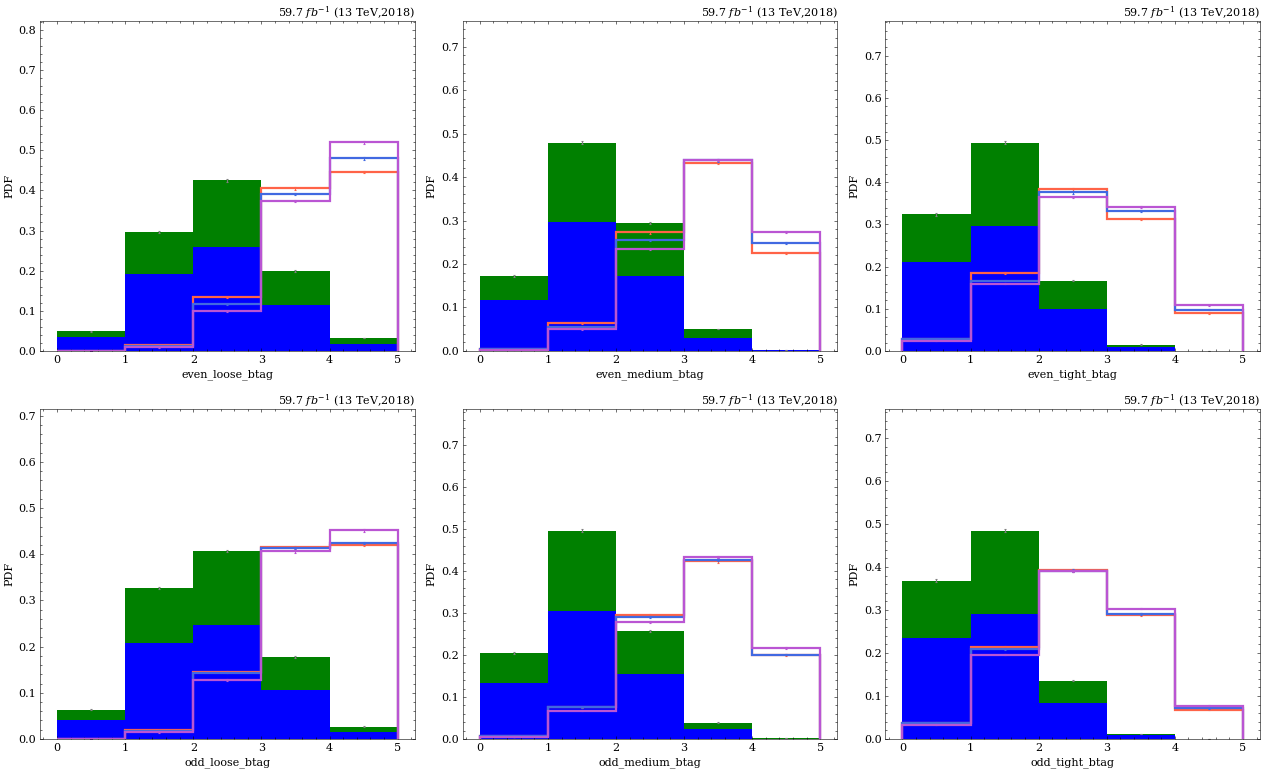

In [11]:
study.quick(
    signal + bkg,
    varlist=[f'{y}_{var}' for y in ('even','odd') for var in ('loose_btag','medium_btag','tight_btag')],
    binlist=[np.arange(6)]*6,
    efficiency=True,
)

100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


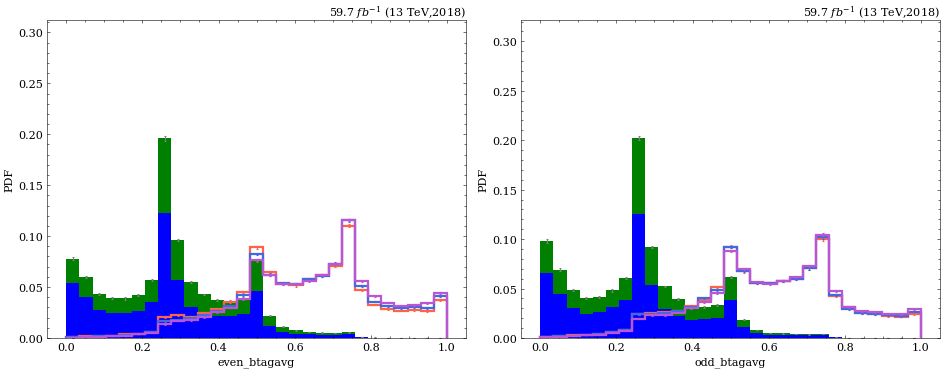

In [69]:
study.quick(
    signal+bkg,
    varlist=['even_btagavg','odd_btagavg'],
    efficiency=True,
)

100%|██████████| 1/1 [00:05<00:00,  5.69s/it]


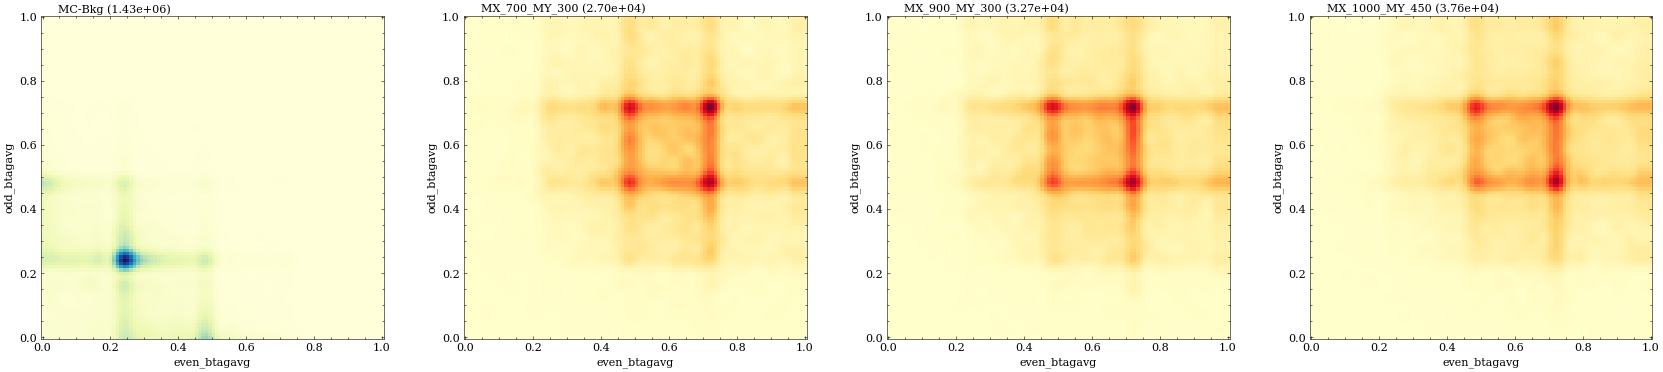

In [76]:
varinfo.btagavg=dict(bins=(0,1,30))

study.quick2d(
    signal+bkg,
    varlist=['even_btagavg','odd_btagavg'],
    # scatter=True,
    interp=dict(kind='linear'),
    # contour=True,
)

100%|██████████| 9/9 [00:14<00:00,  1.56s/it]


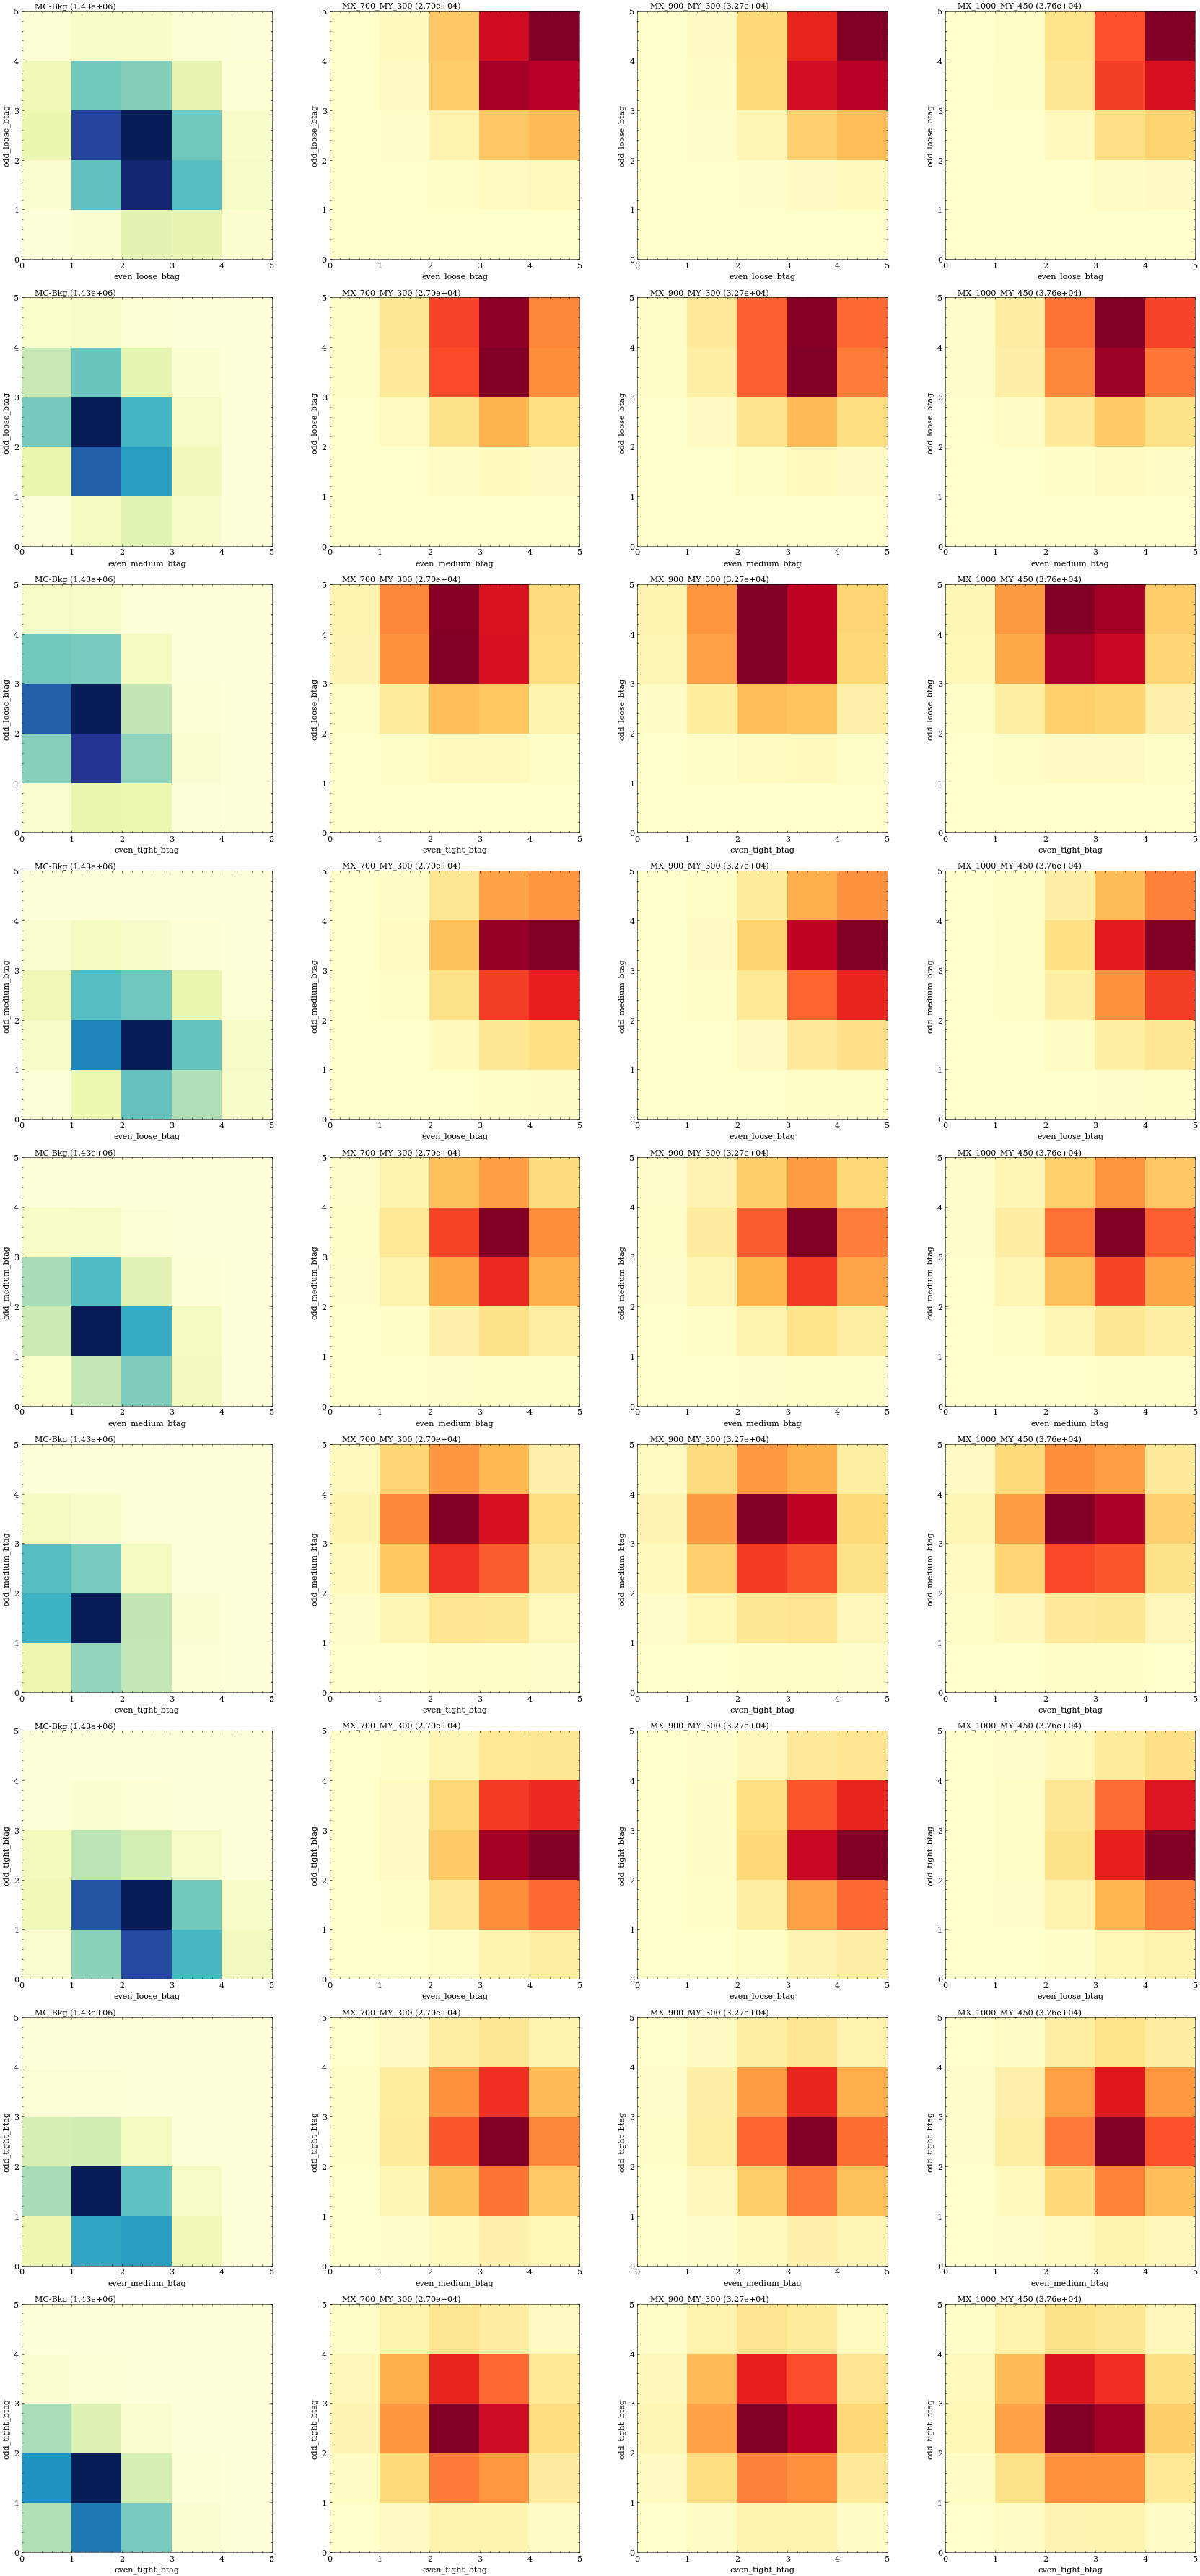

In [36]:
abcd_region = draw_abcd(x_r=(2,3,5), y_r=(1,3,5))
study.quick2d(
    signal+bkg,
    xvarlist=['even_loose_btag', 'even_medium_btag', 'even_tight_btag']*3,
    yvarlist=['odd_loose_btag']*3 + ['odd_medium_btag']*3 + ['odd_tight_btag']*3,
    binlist=[np.arange(6)]*18,
    # exe=abcd_region,
    # scatter=True,
    # contour=True,
    # interp=True,
)
# region_score(**abcd_region.store[0])

In [42]:
def region_score(A, B, C, D):
    k_estm = (C/D)
    k_targ = (A/B)

    error = k_estm/k_targ - 1

    print(
        f"(C/D) K factor: {k_estm:0.3f}\n"
        f"(A/B) K target: {k_targ:0.3f}\n"
        f"ABCD  % error:  {error:0.2%}\n"
        )
        
def score_region(h, x1, x2, x3, y1, y2, y3):
    x, y, w = h.x_array, h.y_array, h.weights
    a = np.sum(w[(x >= x2) & (x < x3) & (y >= y2) & (y < y3)])
    b = np.sum(w[(x >= x1) & (x < x2) & (y >= y2) & (y < y3)])
    c = np.sum(w[(x >= x2) & (x < x3) & (y >= y1) & (y < y2)])
    d = np.sum(w[(x >= x1) & (x < x2) & (y >= y1) & (y < y2)])
    return np.abs( (c/d)*(b/a)-1 )


def sort_regions(RR, z_r, mask=None):
    if mask is not None:
        RR = RR[mask]
        z_r = z_r[mask]
    return RR[z_r.argsort()]

In [38]:
R = ak.combinations(np.arange(6), n=3, axis=0).tolist()
RR = np.array([ (x_r,y_r) for x_r in R for y_r in R])

def grid_region_search(xvar, yvar, threshold=0.1):
    h = Histo2D( getattr(bkg, xvar).cat, getattr(bkg, yvar).cat, weights=bkg.scale.cat )
    z_r = np.array([score_region(h, *x_r, *y_r) for x_r, y_r in tqdm(RR)])
    print(f'N Regions in acceptance ({threshold}):', (z_r < threshold).sum())
    return z_r

In [18]:
y_LL_z_r = grid_region_search('Y1_loose_btag', 'Y2_loose_btag')

100%|██████████| 400/400 [00:13<00:00, 29.97it/s]

N Regions in acceptance (0.1): 51


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


[2 3 5] [1 3 5]
(C/D) K factor: 0.611
(A/B) K target: 0.607
ABCD  % error:  0.51%



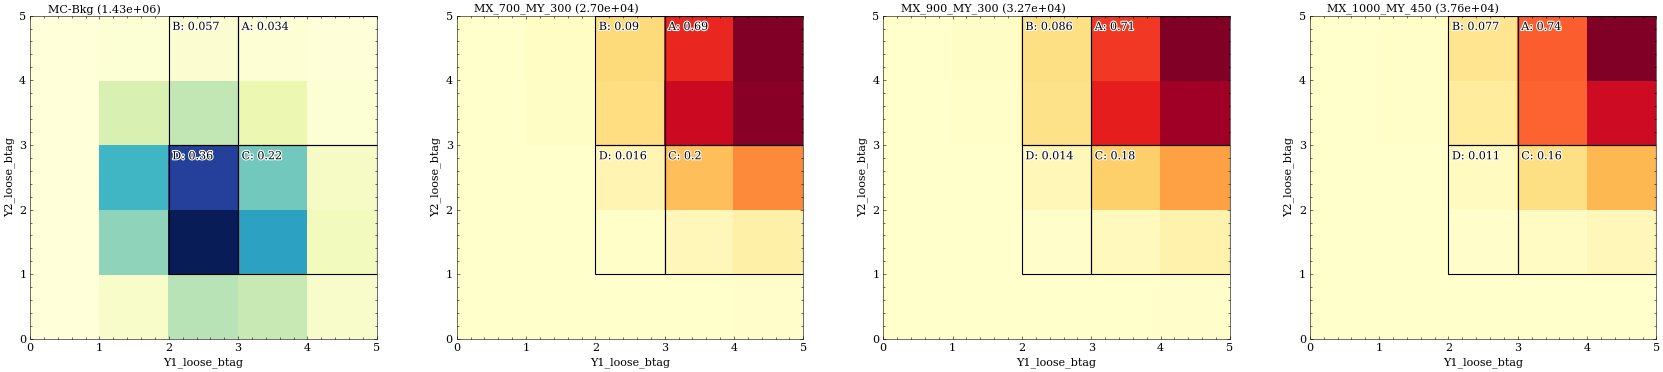

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


[3 4 5] [0 2 3]
(C/D) K factor: 0.166
(A/B) K target: 0.164
ABCD  % error:  1.37%



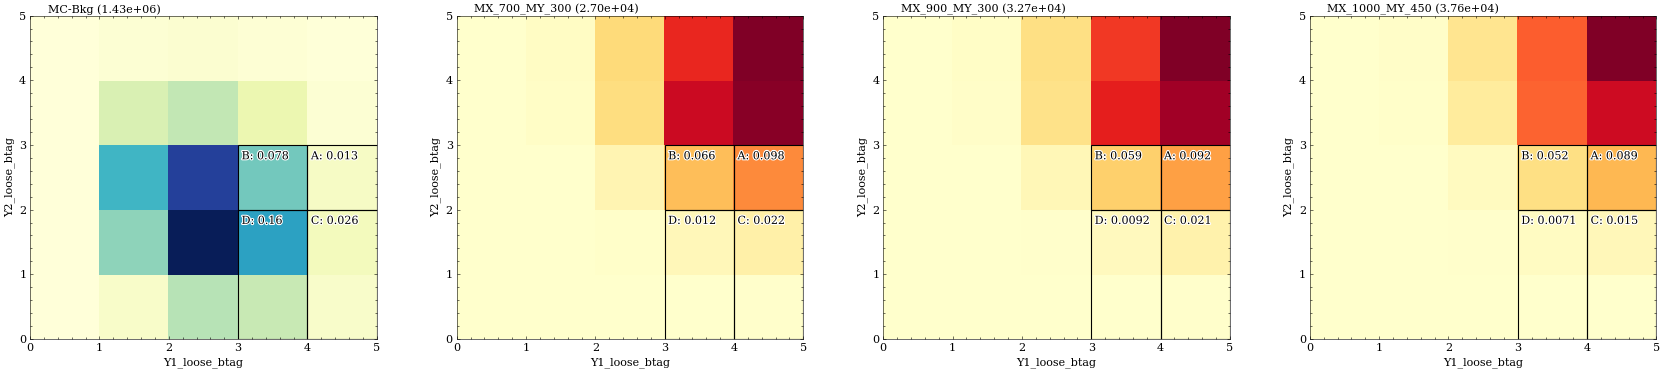

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


[2 4 5] [1 2 3]
(C/D) K factor: 0.055
(A/B) K target: 0.053
ABCD  % error:  4.55%



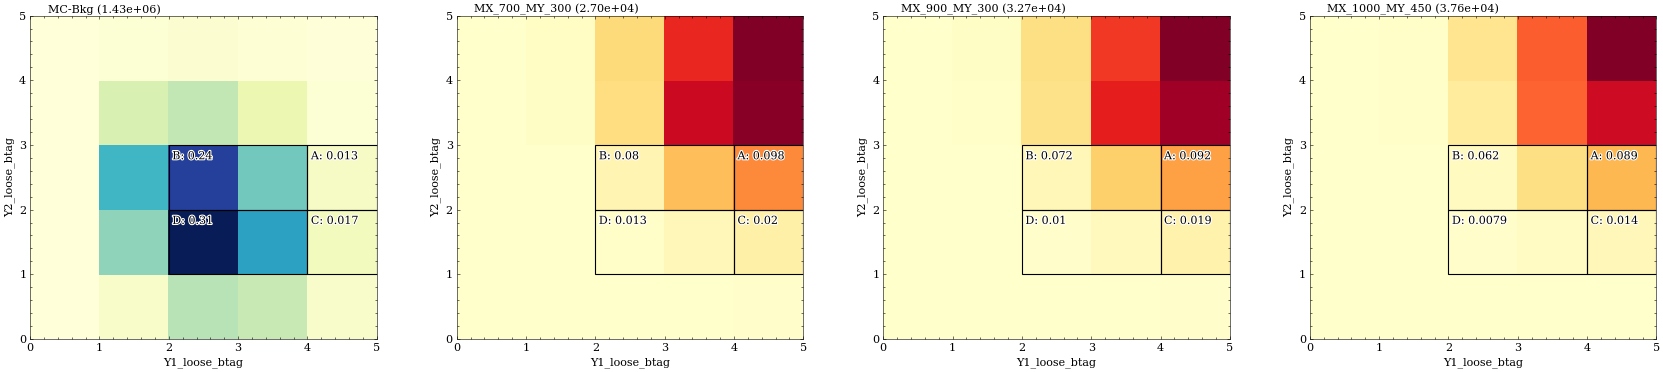

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


[1 2 3] [3 4 5]
(C/D) K factor: 1.357
(A/B) K target: 1.273
ABCD  % error:  6.59%



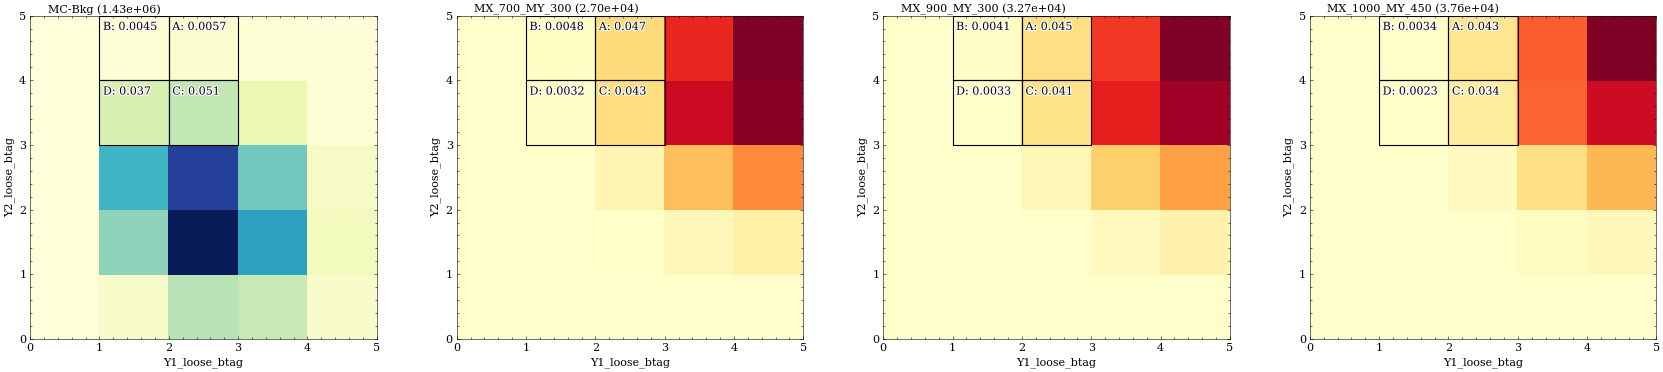

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


[0 2 3] [3 4 5]
(C/D) K factor: 1.357
(A/B) K target: 1.273
ABCD  % error:  6.59%



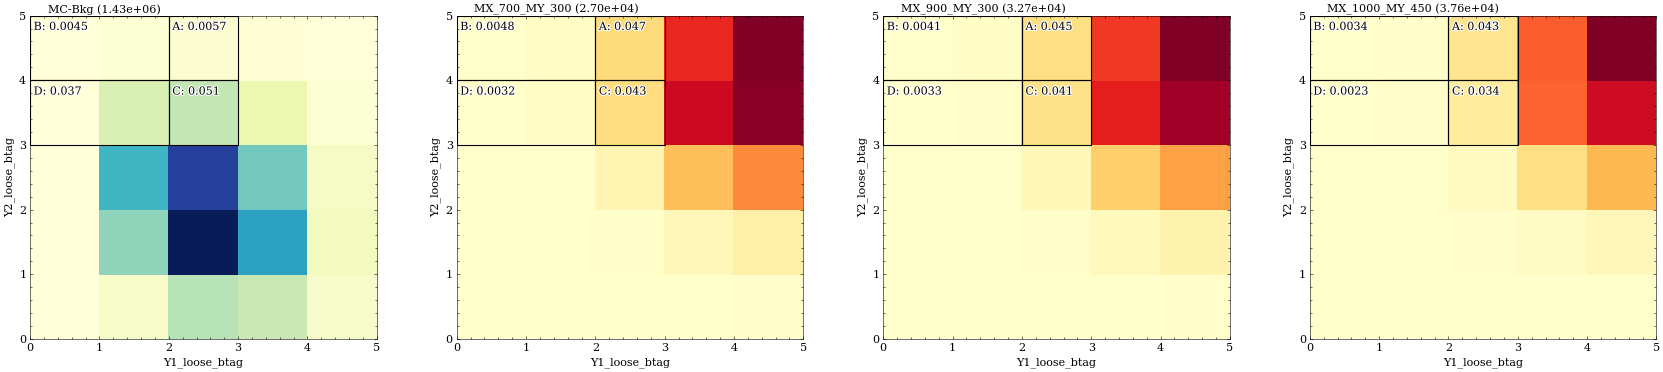

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


[3 4 5] [1 2 3]
(C/D) K factor: 0.152
(A/B) K target: 0.164
ABCD  % error:  -7.03%



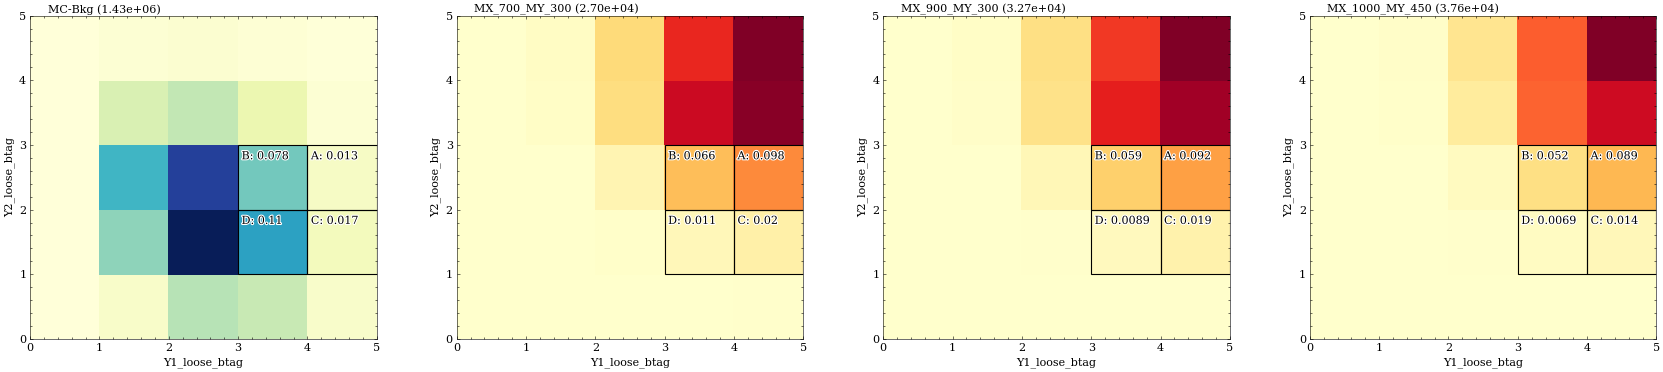

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


[2 3 5] [1 2 3]
(C/D) K factor: 0.657
(A/B) K target: 0.555
ABCD  % error:  18.38%



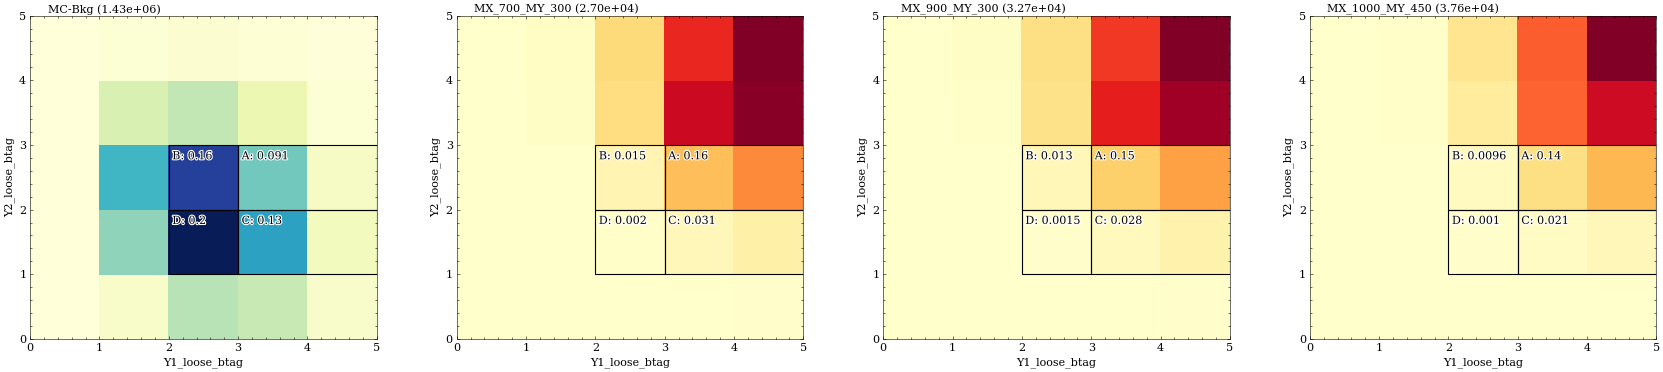

In [44]:
is_sr = (RR[:,0,1] == 3) & (RR[:,1,1] == 3) & (RR[:,0,2] == 5) & (RR[:,1,2] == 5)
has_sr = (RR[:,0,2] > 3) & (RR[:,1,2] > 3)

y_sr = sort_regions(RR, y_LL_z_r, is_sr)[:1]
y_vr = sort_regions(RR, y_LL_z_r, ~has_sr)[:6]
regions = np.concatenate([y_sr ,y_vr])

for x_r, y_r in regions:
    abcd_region = draw_abcd(x_r=x_r, y_r=y_r)
    study.quick2d(
    signal+bkg,
    xvarlist=['Y1_loose_btag'],
    yvarlist=['Y2_loose_btag'],
    binlist=[np.arange(6)]*6,
    exe=abcd_region,
    # interp=True,
    )
    print(x_r, y_r)
    region_score(**abcd_region.store[0])
    plt.show()

In [20]:
LL_z_r = grid_region_search('even_loose_btag', 'odd_loose_btag')

100%|██████████| 400/400 [00:13<00:00, 29.20it/s]

N Regions in acceptance (0.1): 38


100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


[2 3 5] [2 3 5]
(C/D) K factor: 0.458
(A/B) K target: 0.480
ABCD  % error:  -4.54%



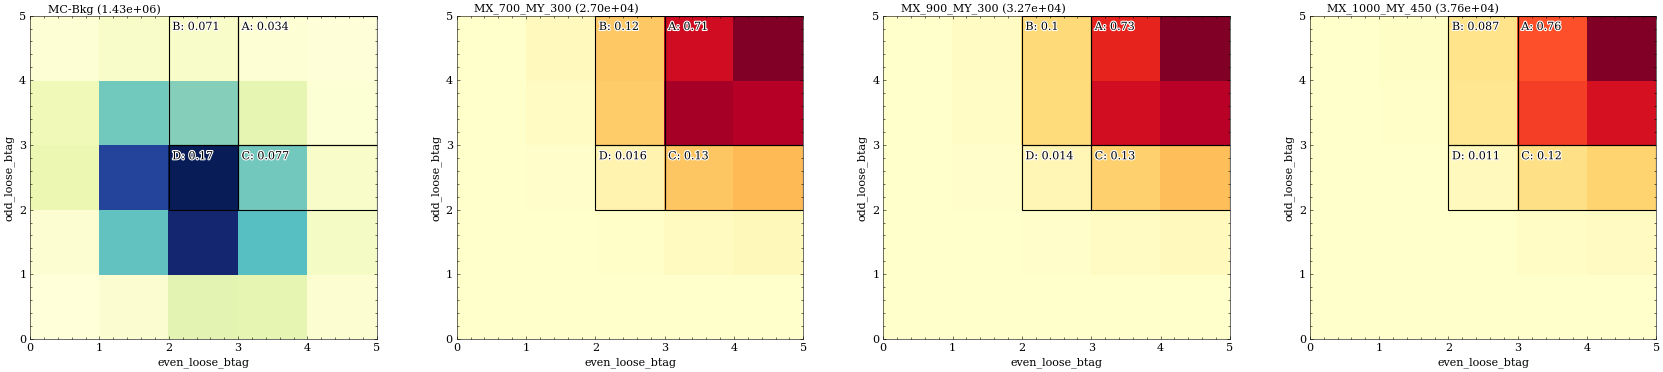

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


[0 2 3] [3 4 5]
(C/D) K factor: 0.717
(A/B) K target: 0.743
ABCD  % error:  -3.49%



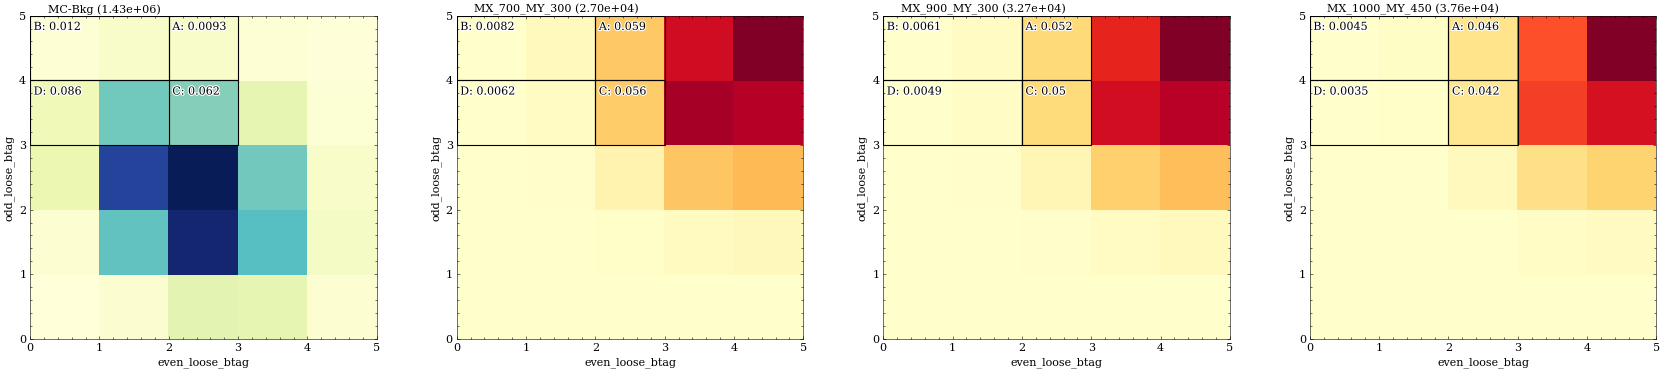

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


[1 2 3] [2 4 5]
(C/D) K factor: 1.105
(A/B) K target: 1.031
ABCD  % error:  7.18%



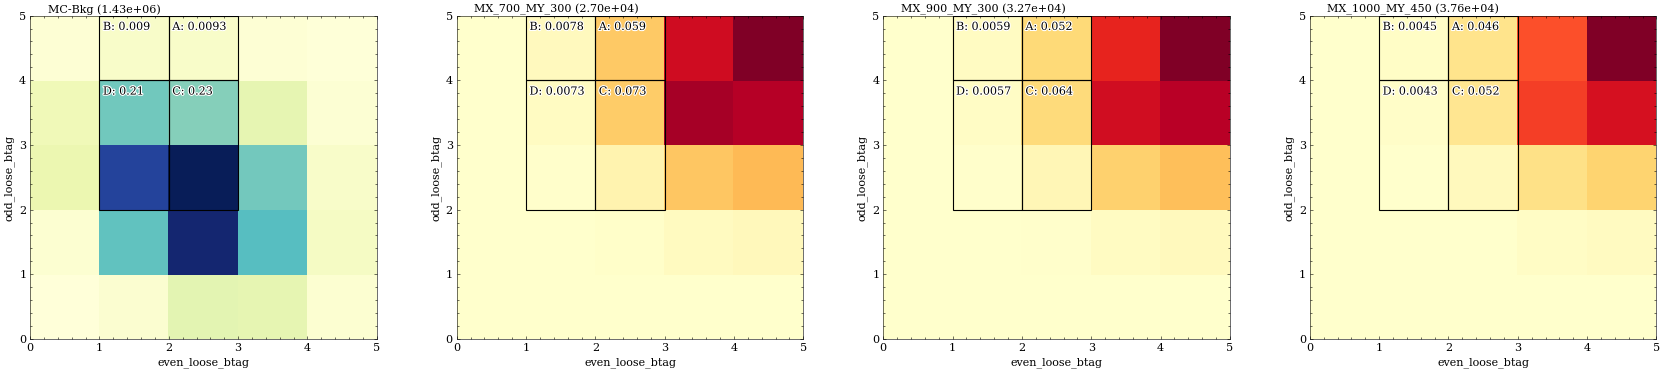

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


[0 1 2] [0 1 2]
(C/D) K factor: 13.590
(A/B) K target: 14.959
ABCD  % error:  -9.15%



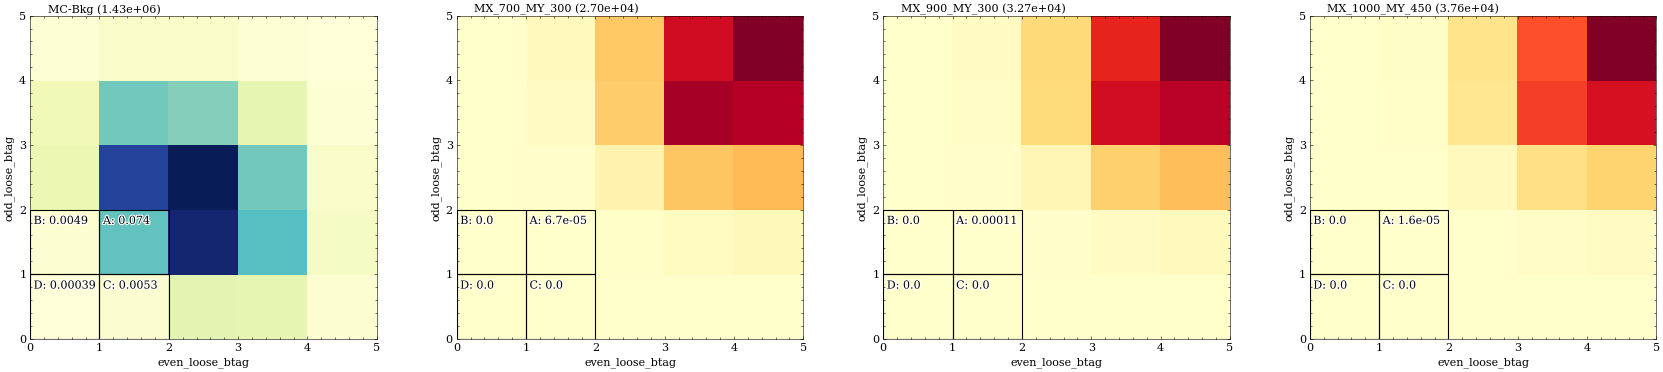

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


[3 4 5] [1 2 3]
(C/D) K factor: 0.158
(A/B) K target: 0.142
ABCD  % error:  11.38%



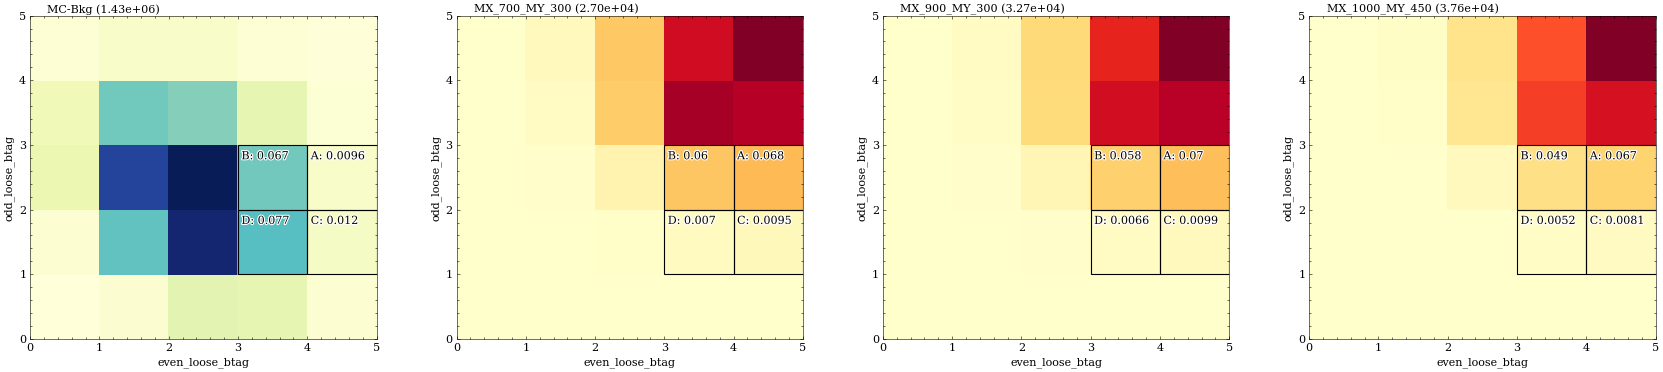

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


[1 2 3] [3 4 5]
(C/D) K factor: 0.900
(A/B) K target: 1.031
ABCD  % error:  -12.69%



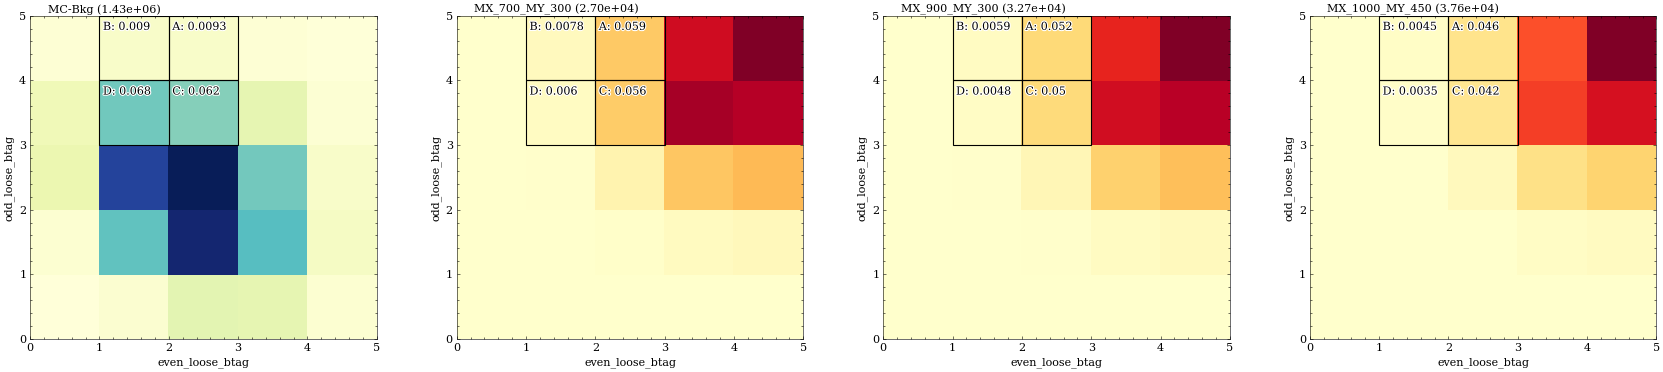

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


[3 4 5] [0 2 3]
(C/D) K factor: 0.166
(A/B) K target: 0.142
ABCD  % error:  16.97%



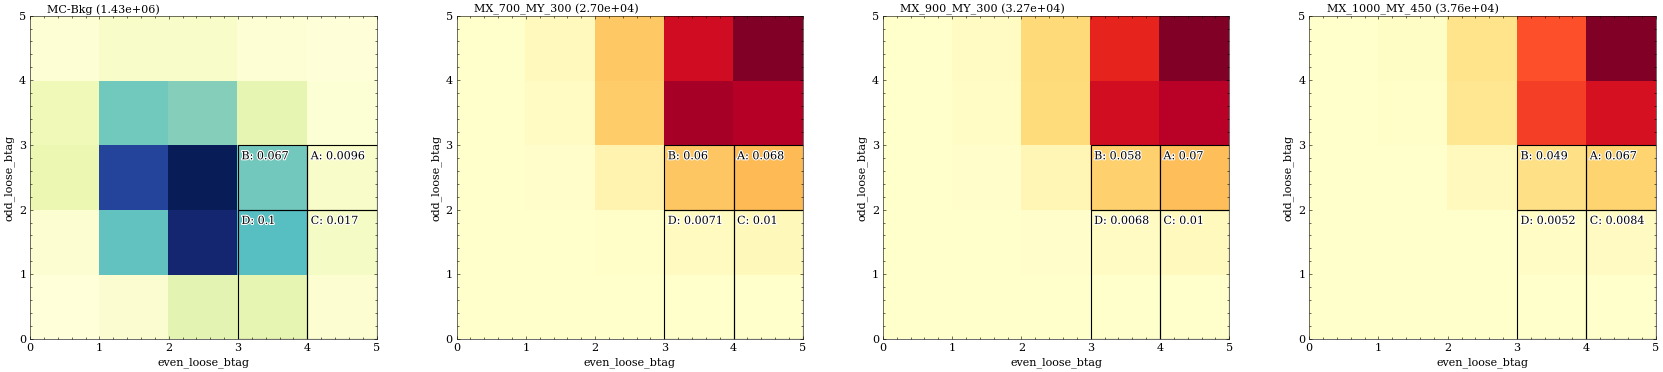

In [45]:
is_sr = (RR[:,0,1] == 3) & (RR[:,1,1] == 3) & (RR[:,0,2] == 5) & (RR[:,1,2] == 5)
has_sr = (RR[:,0,2] > 3) & (RR[:,1,2] > 3)

eo_sr = sort_regions(RR, LL_z_r, is_sr)[:1]
eo_vr = sort_regions(RR, LL_z_r, ~has_sr)[:6]
regions = np.concatenate([eo_sr, eo_vr])
for x_r, y_r in regions:
    abcd_region = draw_abcd(x_r=x_r, y_r=y_r)
    study.quick2d(
    signal+bkg,
    xvarlist=['even_loose_btag'],
    yvarlist=['odd_loose_btag'],
    binlist=[np.arange(6)]*6,
    exe=abcd_region,
    # interp=True,
    )
    print(x_r, y_r)
    region_score(**abcd_region.store[0])
    plt.show()

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


[2 3 4] [1 2 3] (0.20352011935781467, 0.4831000384413775, 0.40140586822857144)


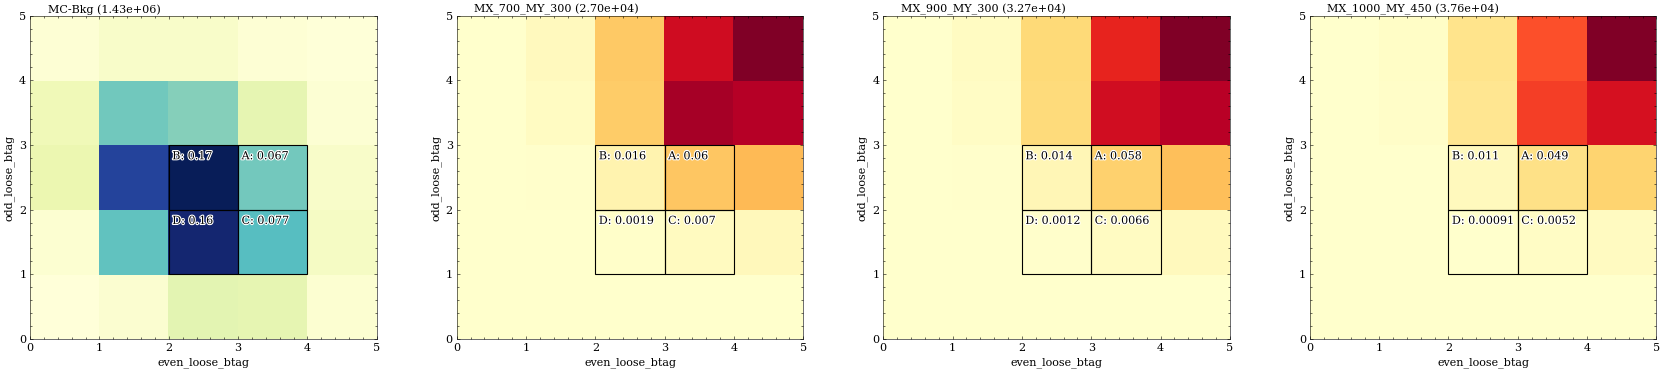

In [27]:
is_sr = (RR[:,0,1] == 3) & (RR[:,1,1] == 3) & (RR[:,0,2] == 5) & (RR[:,1,2] == 5)
has_sr = (RR[:,0,2] > 3) & (RR[:,1,2] > 3)

test_vr = sort_regions(RR, LL_z_r, (RR[:,0,2]==4)&(RR[:,1,2]==3))[:1]

for x_r, y_r in test_vr:
    abcd_region = draw_abcd(x_r=x_r, y_r=y_r)
    study.quick2d(
    signal+bkg,
    xvarlist=['even_loose_btag'],
    yvarlist=['odd_loose_btag'],
    binlist=[np.arange(6)]*6,
    exe=abcd_region,
    # interp=True,
    )
    print(x_r, y_r, region_score(**abcd_region.store[0]))
    plt.show()

In [59]:
def discrete_abcd(x_v, y_v, x_r, y_r):
    x1, x2, x3 = x_r
    y1, y2, y3 = y_r
    return dict(
        a = lambda t : (t[x_v] >= x2) & (t[x_v] < x3) & (t[y_v] >= y2) & (t[y_v] < y3),
        b = lambda t : (t[x_v] >= x1) & (t[x_v] < x2) & (t[y_v] >= y2) & (t[y_v] < y3),
        c = lambda t : (t[x_v] >= x2) & (t[x_v] < x3) & (t[y_v] >= y1) & (t[y_v] < y2),
        d = lambda t : (t[x_v] >= x1) & (t[x_v] < x2) & (t[y_v] >= y1) & (t[y_v] < y2)
    )

In [63]:
def train_and_evaluate(features, x_v, y_v, x_r, y_r):
    bdt = ABCD(
        features=features,
        **discrete_abcd(x_v, y_v, x_r, y_r)
    )
    bdt.train(bkg)
    bdt.print_results(bkg)

    study.quick2d(
        signal+bkg,
        xvarlist=[x_v],
        yvarlist=[y_v],
        binlist=[np.arange(6)]*6,
        exe=draw_abcd(x_r=x_r, y_r=y_r),
    )
    plt.show()
    
    study.quick_region(
        bkg, bkg, label=['MC-Target','MC-Model'], legend=True,
        masks=[bdt.a]*len(bkg) + [bdt.b]*len(bkg),
        scale=[1]*len(bkg) + [bdt.reweight_tree]*len(bkg),
        varlist=['X_m','X_pt','X_eta','X_phi'],
        dim=(-1, 4),
        ratio=True,

        empirical=True, e_show=False,
        e_difference=True, e_d_legend=True, e_d_legend_frameon=True,
    )

    plt.show()

    fig, axs = study.get_figax(2)
    study.quick(
        signal+bkg, legend=True,
        stack_fill=True,
        masks=[bdt.a]*len(signal)+[bdt.a]*len(bkg),
        varlist=['X_m'],
        limits=True,
        title='No Modeling',
        figax=(fig, axs[0])
    )

    study.quick(
        signal+bkg, legend=True,
        stack_fill=True,
        masks=[bdt.a]*len(signal)+[bdt.b]*len(bkg),
        scale=[1]*len(signal)+[bdt.reweight_tree]*len(bkg),
        varlist=['X_m'],
        limits=True,
        title='With BDT Model',
        figax=(fig, axs[1])
    )
    plt.show()

    return bdt

In [61]:
# y_regions = dict(
#     ar =discrete_abcd(*y_sr[0], x_v='Y1_loose_btag', y_v='Y2_loose_btag'),
# )

# eo_regions = dict(
#     ar =discrete_abcd(*eo_sr[0], x_v='even_loose_btag', y_v='odd_loose_btag'),
#     vr1=discrete_abcd(*eo_vr[0], x_v='even_loose_btag', y_v='odd_loose_btag'),
#     vr2=discrete_abcd(*test_vr[0], x_v='even_loose_btag', y_v='odd_loose_btag'),
# )

--- ABCD Results ---
k = 6.105e-01
k*(b/a)-1  = 0.51%
BDT(b)/a-1 = 1.51%



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


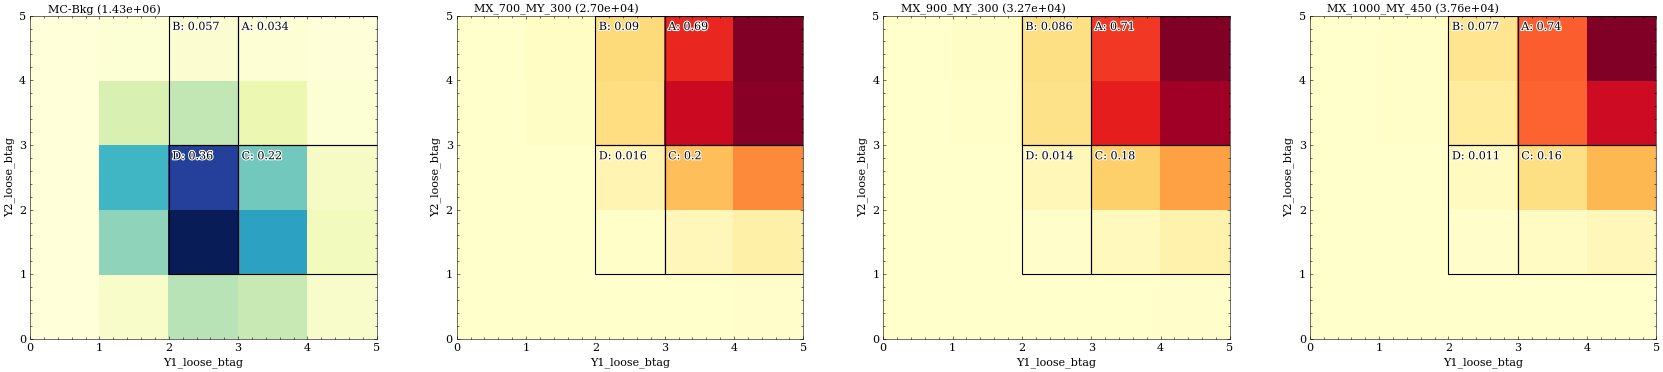

100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


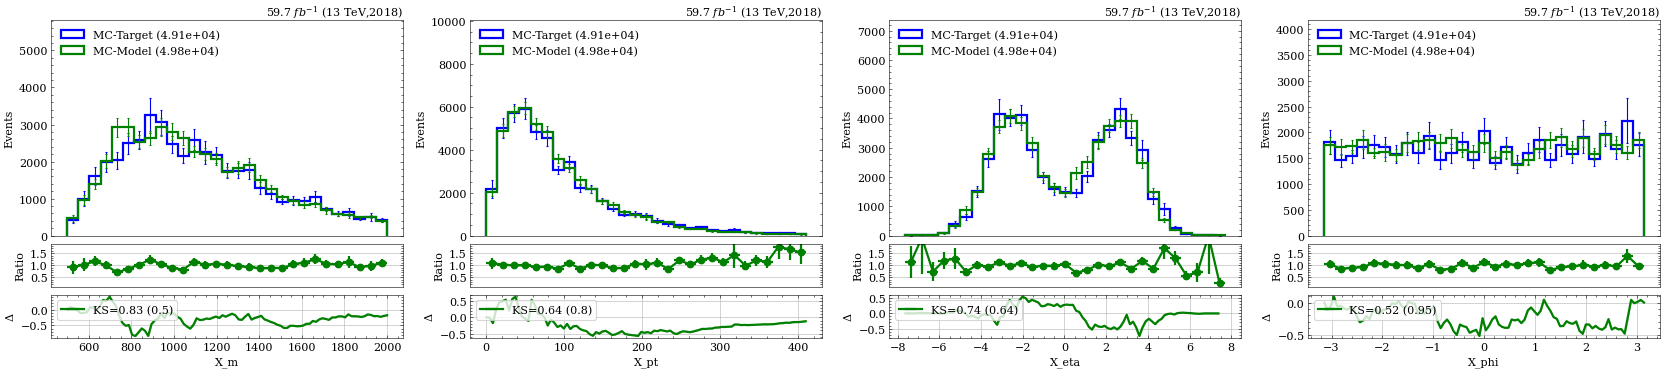

100%|██████████| 1/1 [00:13<00:00, 13.37s/it]


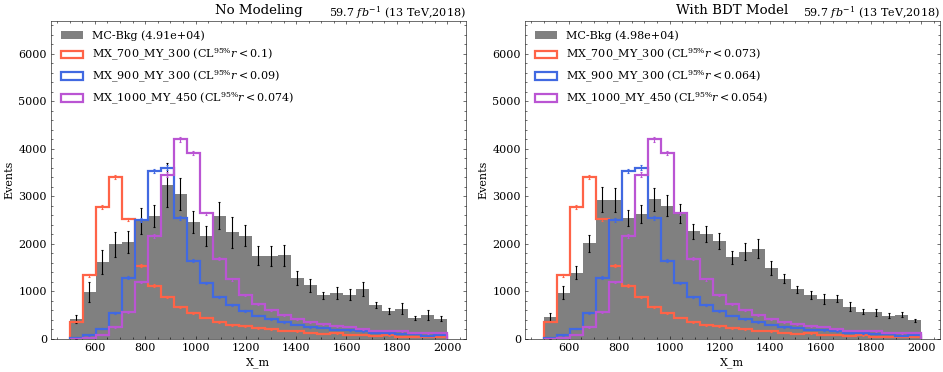

In [64]:
train_and_evaluate(
    features=['X_m','X_pt','X_eta','X_phi'],
    x_v='Y1_loose_btag', y_v='Y2_loose_btag',
    x_r=y_sr[0][0], y_r=y_sr[0][1]
)

--- ABCD Results ---
k = 4.583e-01
k*(b/a)-1  = -4.54%
BDT(b)/a-1 = -4.18%



100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


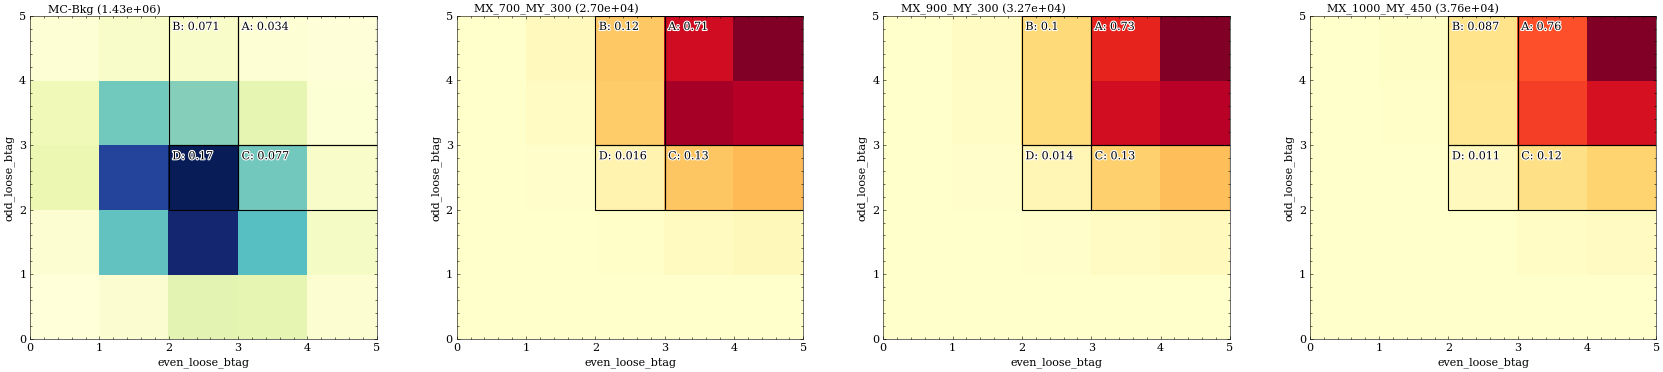

100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


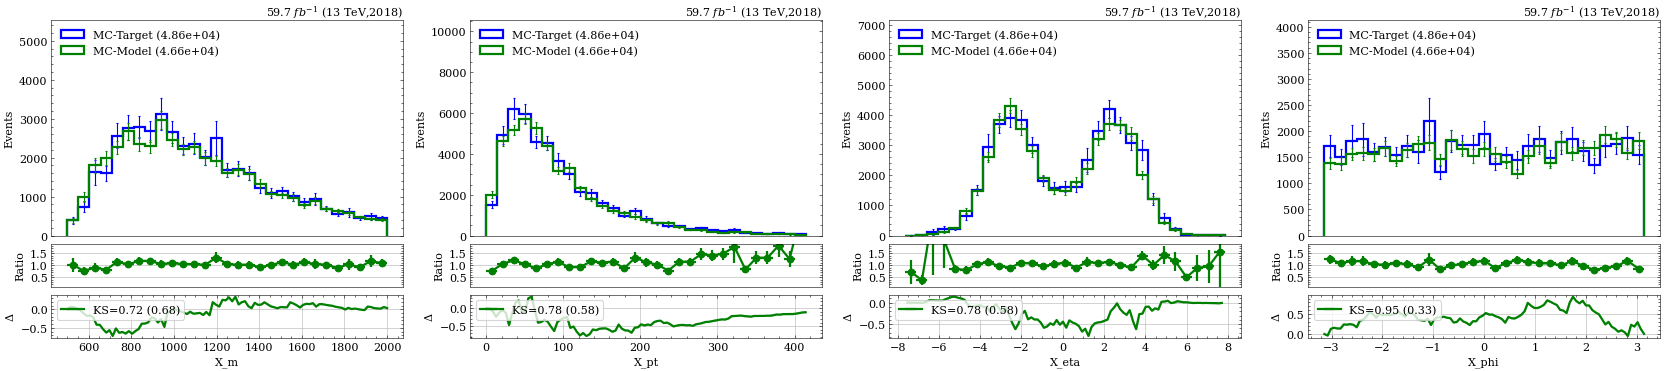

100%|██████████| 1/1 [00:13<00:00, 13.13s/it]


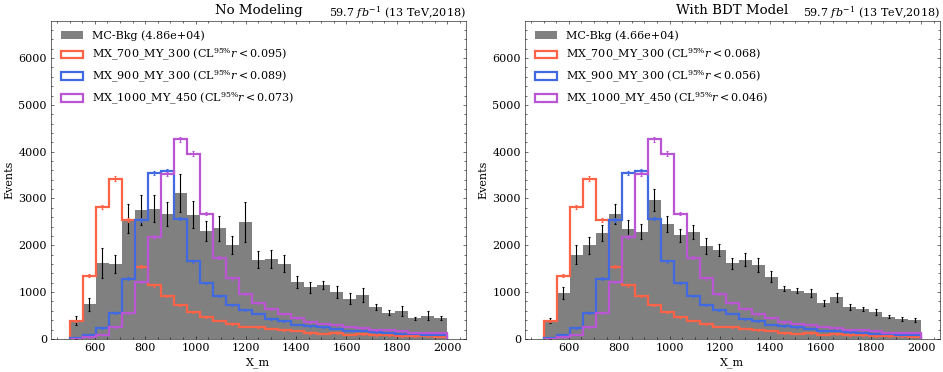

In [65]:
train_and_evaluate(
    features=['X_m','X_pt','X_eta','X_phi'],
    x_v='even_loose_btag', y_v='odd_loose_btag',
    x_r=eo_sr[0][0], y_r=eo_sr[0][1]
)

--- ABCD Results ---
k = 4.831e-01
k*(b/a)-1  = 20.35%
BDT(b)/a-1 = 20.72%



100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


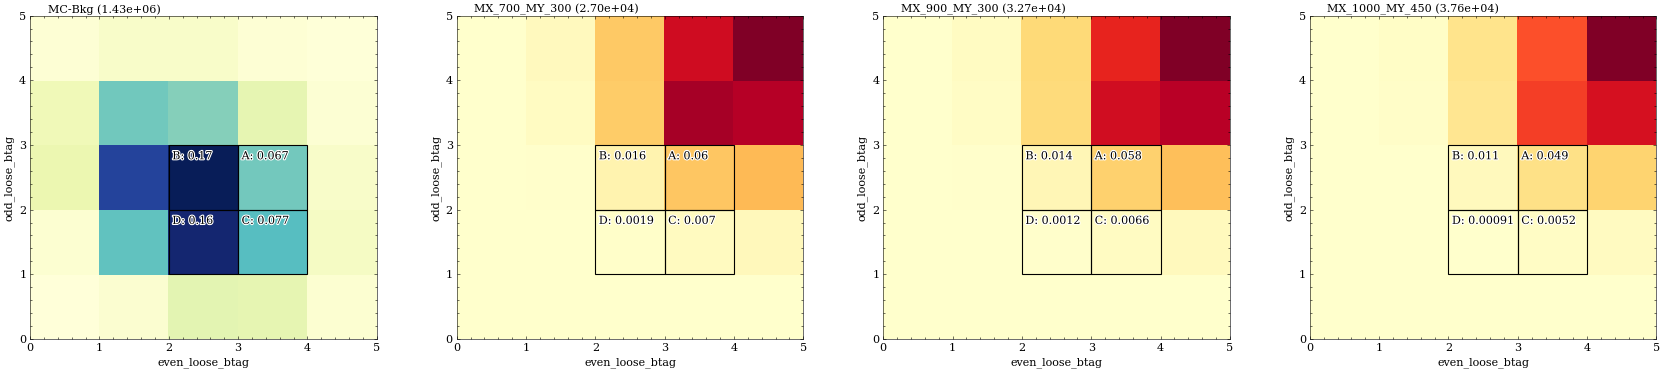

100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


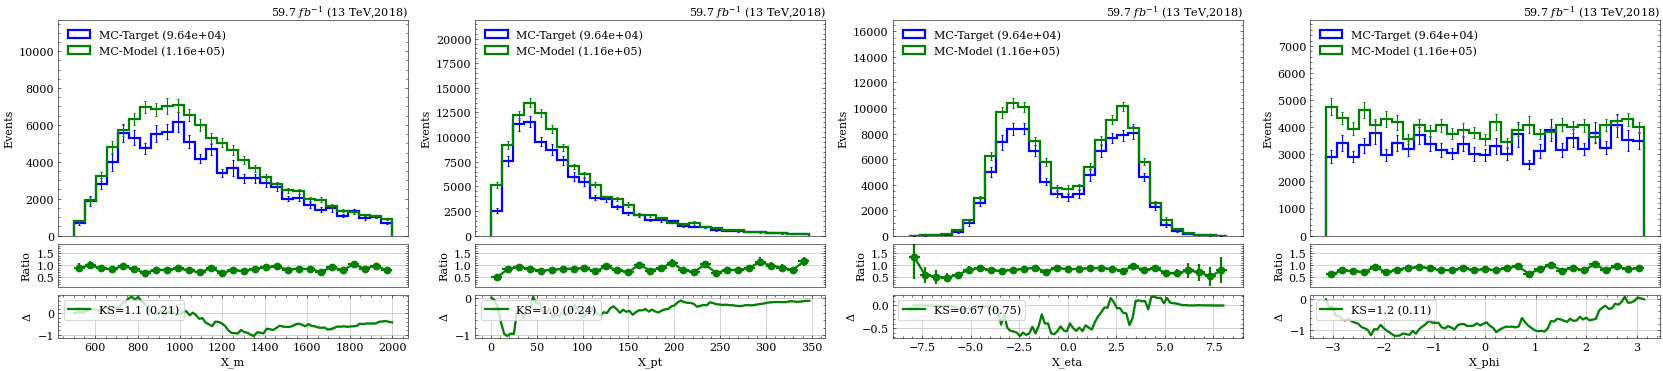

100%|██████████| 1/1 [00:13<00:00, 13.47s/it]


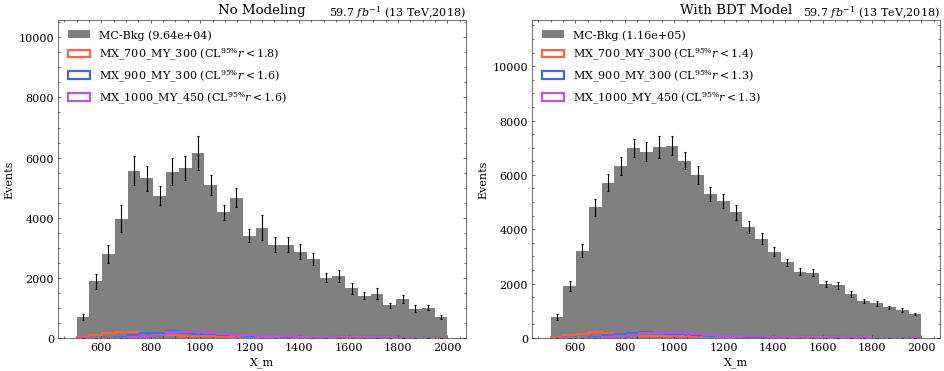

In [66]:
train_and_evaluate(
    features=['X_m','X_pt','X_eta','X_phi'],
    x_v='even_loose_btag', y_v='odd_loose_btag',
    x_r=test_vr[0][0], y_r=test_vr[0][1]
)